In [1]:
import os
#os.chdir('~')
import factor_selection as FS
import pandas as pd
import numpy as np
import datetime, time
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from WindPy import w
w.start() 

C:\Users\ZYLD\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2017 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

### Get dataset

In [2]:
# iron price
startdate=(datetime.date.today()-datetime.timedelta(365*5)).strftime('%Y-%m-%d') # 5 years
enddate=(datetime.date.today()).strftime('%Y-%m-%d') # full samples

iron_price = w.wsd("I00.DCE", "open,high,low,close,pct_chg,swing", startdate, enddate, "TradingCalendar=DCE")
wind_to_df = lambda x: pd.DataFrame(x.Data, columns=x.Times,index=x.Fields).T
iron_price = wind_to_df(iron_price)


# emotion factors: 20-day and 40-day price trend
iron_price['20-DAYS CHG'] = FS.margin(iron_price, "CLOSE", 20)
iron_price['40-DAYS CHG'] = FS.margin(iron_price, "CLOSE", 40)

In [3]:
# macro factor
macro_data = w.edb("M0041572,S5709303,S5709297,S0116906,S0116891,S0148686,\
                    S5709288,S5705131,S5709309,S5713339,S5713341,S5713286,\
                    S0031703,S0027378,M0251664,S5713303,S5713327,S5713285", startdate, enddate,"Fill=Previous")
wind_to_df = lambda x: pd.DataFrame(x.Data, columns=x.Times, index=x.Codes).T
macro_data = wind_to_df(macro_data)
macro_data.index=pd.to_datetime(macro_data.index)

### Preprocessing

In [4]:
# put factors into lists according to update frequency
yearly_f = ['S0116906', 'M0251664']
monthly_f = ['M0041572','S0116891','S0148686','S0027378']
weekly_f = ['S5705131','S5713286','S0031703','S5713303','S5713327']
daily_f = ['S5709303','S5709297','S5709288','S5709309']
# update lagged info to avoid future data
macro_lagadj = FS.update_lag(macro_data, yearly_f, monthly_f, weekly_f, daily_f)

# Better use margin value for demand factor according to the research report
demand_fac = ['S0031703','S0027378','M0251664','S5713303','S5713327','S5713285']
for fac in demand_fac:
    macro_lagadj[fac] = FS.margin(macro_lagadj, fac, 1)

# concat factors and prices
macro_reindex = macro_lagadj.reindex(iron_price.index)
iron_concat = pd.concat([macro_reindex, iron_price], axis=1)

# adjust columns position for later use
iron_cut = iron_concat.drop(["OPEN","HIGH","LOW"], axis=1)
col_list = list(iron_cut)
col_list.insert(-4, col_list.pop(col_list.index('20-DAYS CHG')))
col_list.insert(-3, col_list.pop(col_list.index('40-DAYS CHG')))
iron_cut = iron_cut.loc[:, col_list]

# clean data
iron_clean = FS.raw_data_clean(iron_cut).get_newdata().ffill()

number of missing values for each column:
M0041572        856
S5709303        866
S5709297        866
S0116906        959
S0116891        856
S0148686        856
S5709288        866
S5705131        849
S5709309        866
S5713339        976
S5713341        976
S5713286        969
S0031703        853
S0027378        856
M0251664        962
S5713303        970
S5713327        970
S5713285       1029
20-DAYS CHG     122
40-DAYS CHG     142
CLOSE           102
PCT_CHG         102
SWING           534
dtype: int64
The time span of this dataset is:
 2015-12-31 00:00:00 - 2018-05-28 00:00:00


In [8]:
# correlation test
del_pairs = FS.get_correlated(iron_clean.iloc[:,:-3], thre=0.8)
del_col = ['S0116891','S5709303','S5709288','S5713341','S0116906']
iron_clean = iron_clean.drop(del_col, axis=1)

Correlated factors are:  M0041572 S0116891
Correlated factors are:  S5709303 S5709297
Correlated factors are:  S5709303 S5709288
Correlated factors are:  S5709297 S5709288
Correlated factors are:  S0116906 S5705131
Correlated factors are:  S5713339 S5713341


The factor is: M0041572


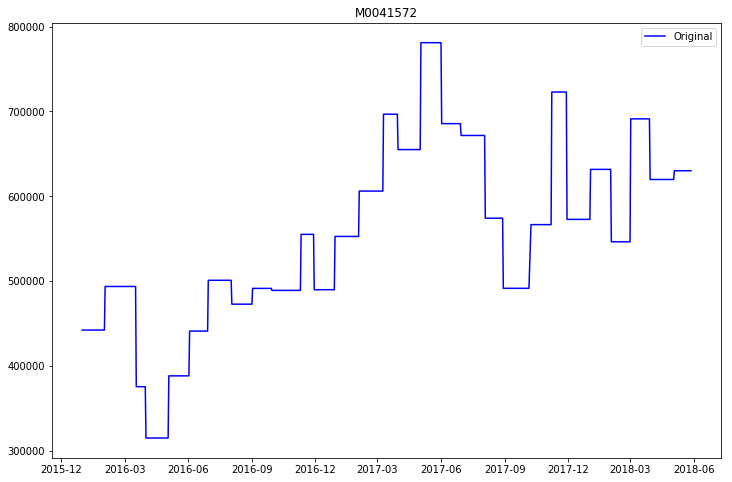

Results of Dickey-Fuller Test:
Test Statistic                  -2.120329
p-value                          0.236419
#Lags Used                       0.000000
Number of Observations Used    627.000000
Critical Value (1%)             -3.440823
Critical Value (5%)             -2.866161
Critical Value (10%)            -2.569231
dtype: float64

The series is not smooth, please do seasonal adjustment.
The factor is: S5709303


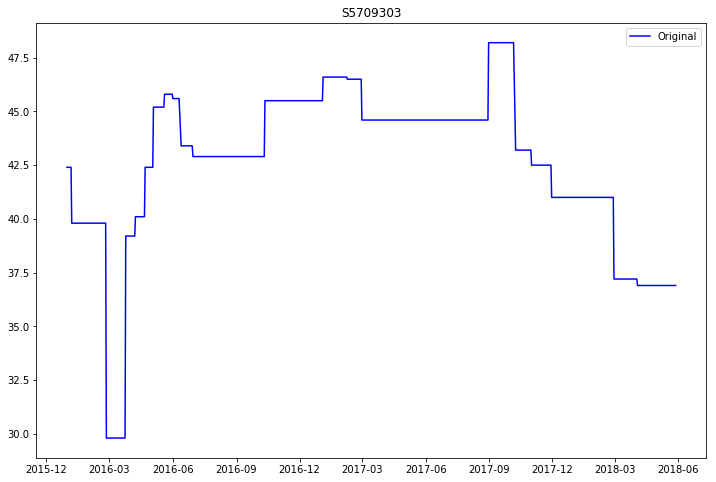

Results of Dickey-Fuller Test:
Test Statistic                  -2.004320
p-value                          0.284682
#Lags Used                       0.000000
Number of Observations Used    627.000000
Critical Value (1%)             -3.440823
Critical Value (5%)             -2.866161
Critical Value (10%)            -2.569231
dtype: float64

The series is not smooth, please do seasonal adjustment.
The factor is: S5709297


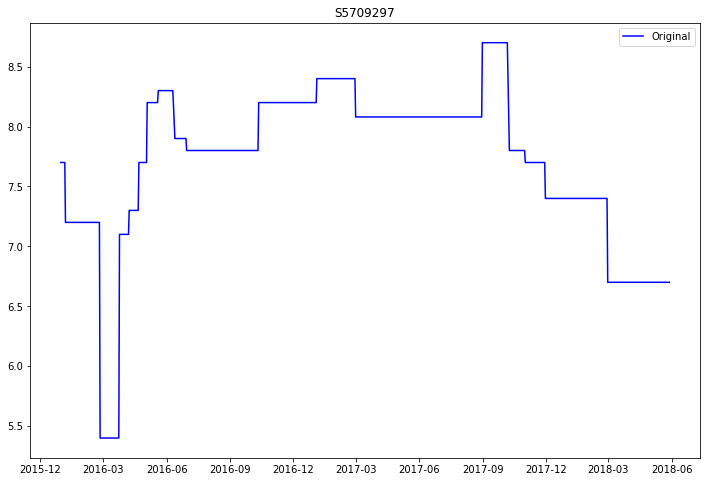

Results of Dickey-Fuller Test:
Test Statistic                  -2.009493
p-value                          0.282426
#Lags Used                       0.000000
Number of Observations Used    627.000000
Critical Value (1%)             -3.440823
Critical Value (5%)             -2.866161
Critical Value (10%)            -2.569231
dtype: float64

The series is not smooth, please do seasonal adjustment.
The factor is: S0116906


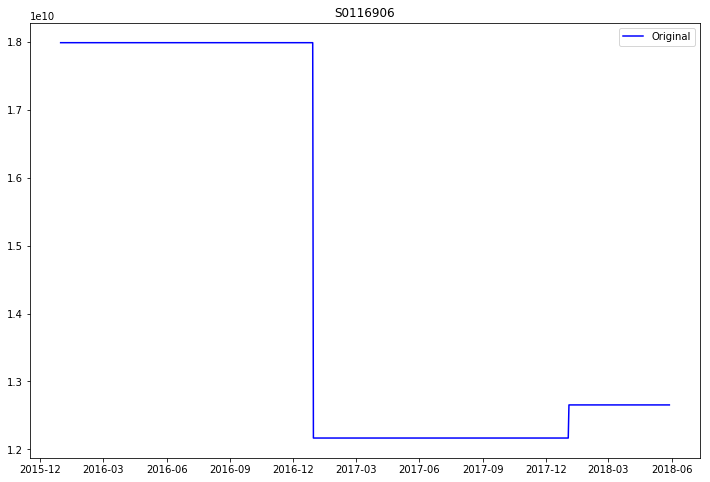

Results of Dickey-Fuller Test:
Test Statistic                  -1.252786
p-value                          0.650487
#Lags Used                       0.000000
Number of Observations Used    627.000000
Critical Value (1%)             -3.440823
Critical Value (5%)             -2.866161
Critical Value (10%)            -2.569231
dtype: float64

The series is not smooth, please do seasonal adjustment.
The factor is: S0116891


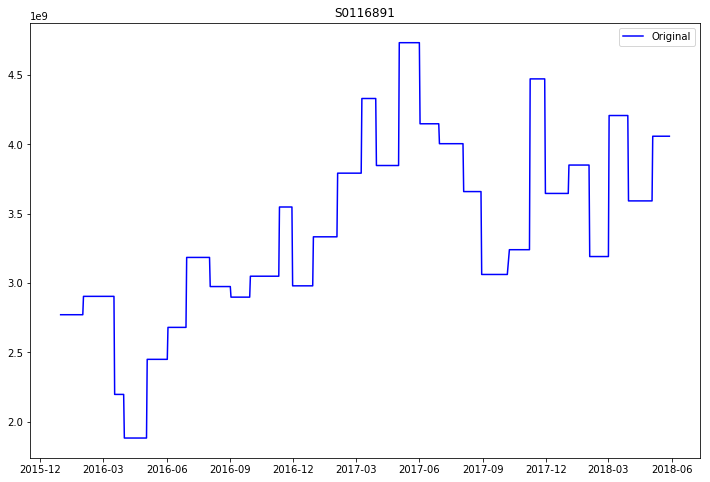

Results of Dickey-Fuller Test:
Test Statistic                  -2.257386
p-value                          0.186080
#Lags Used                       0.000000
Number of Observations Used    627.000000
Critical Value (1%)             -3.440823
Critical Value (5%)             -2.866161
Critical Value (10%)            -2.569231
dtype: float64

The series is not smooth, please do seasonal adjustment.
The factor is: S0148686


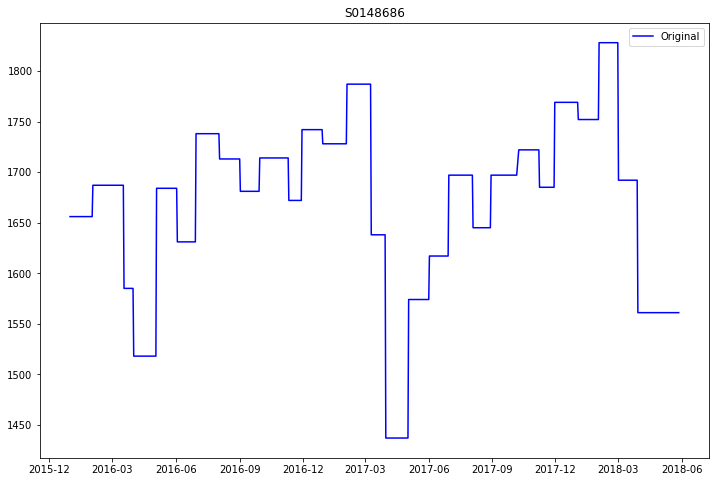

Results of Dickey-Fuller Test:
Test Statistic                  -2.626061
p-value                          0.087730
#Lags Used                       0.000000
Number of Observations Used    627.000000
Critical Value (1%)             -3.440823
Critical Value (5%)             -2.866161
Critical Value (10%)            -2.569231
dtype: float64

The series is not smooth, please do seasonal adjustment.
The factor is: S5709288


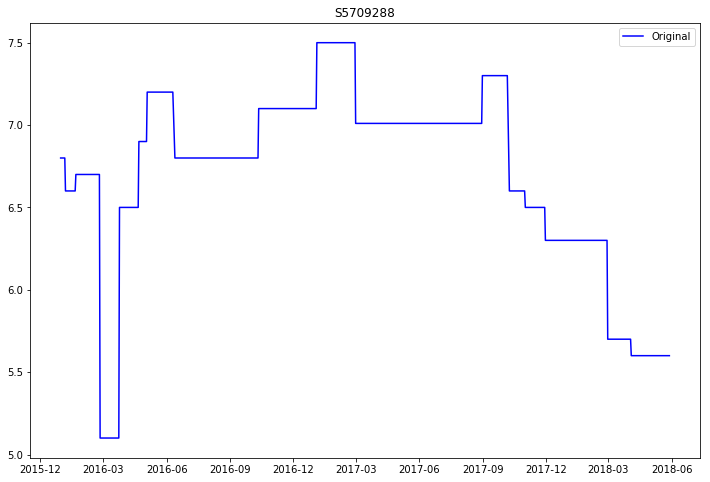

Results of Dickey-Fuller Test:
Test Statistic                  -1.831156
p-value                          0.365107
#Lags Used                       0.000000
Number of Observations Used    627.000000
Critical Value (1%)             -3.440823
Critical Value (5%)             -2.866161
Critical Value (10%)            -2.569231
dtype: float64

The series is not smooth, please do seasonal adjustment.
The factor is: S5705131


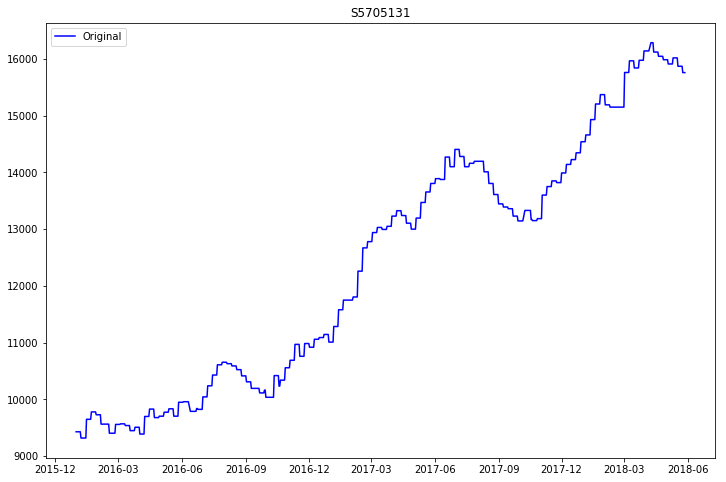

Results of Dickey-Fuller Test:
Test Statistic                  -0.377634
p-value                          0.913767
#Lags Used                       5.000000
Number of Observations Used    622.000000
Critical Value (1%)             -3.440907
Critical Value (5%)             -2.866198
Critical Value (10%)            -2.569251
dtype: float64

The series is not smooth, please do seasonal adjustment.
The factor is: S5709309


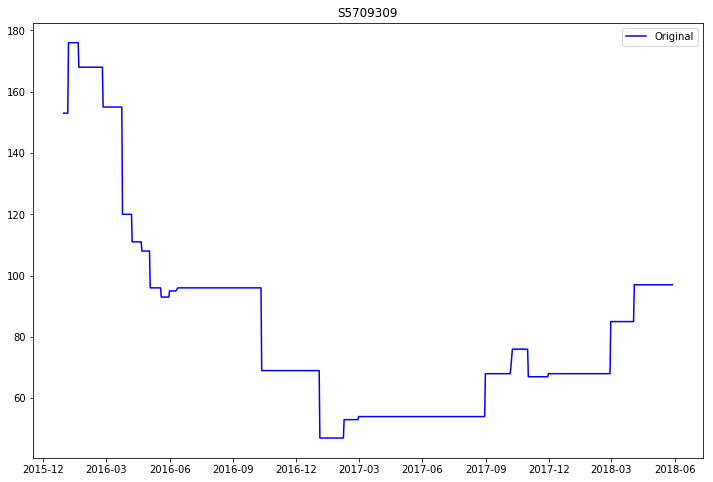

Results of Dickey-Fuller Test:
Test Statistic                  -2.134522
p-value                          0.230862
#Lags Used                       0.000000
Number of Observations Used    627.000000
Critical Value (1%)             -3.440823
Critical Value (5%)             -2.866161
Critical Value (10%)            -2.569231
dtype: float64

The series is not smooth, please do seasonal adjustment.
The factor is: S5713339


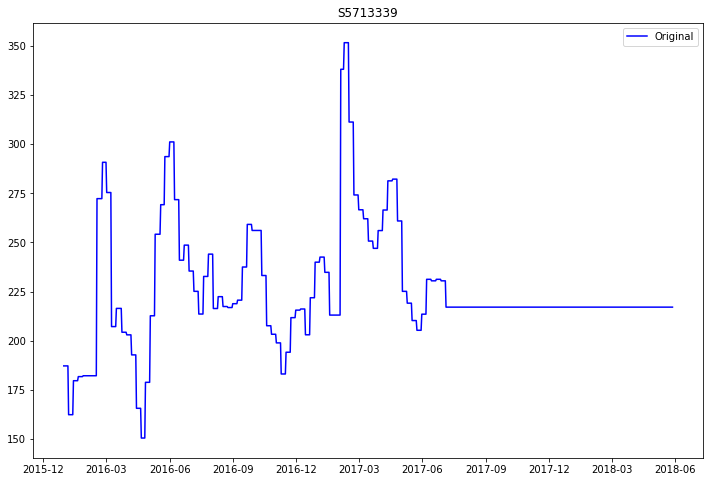

Results of Dickey-Fuller Test:
Test Statistic                  -5.038200
p-value                          0.000019
#Lags Used                       8.000000
Number of Observations Used    619.000000
Critical Value (1%)             -3.440958
Critical Value (5%)             -2.866221
Critical Value (10%)            -2.569263
dtype: float64
The factor is: S5713341


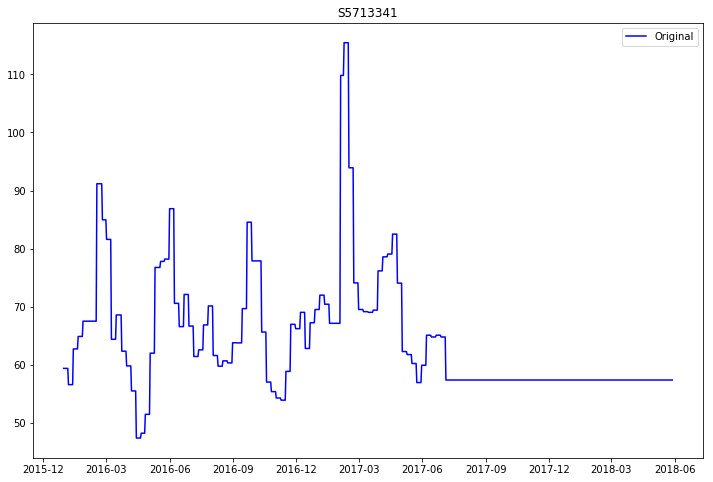

Results of Dickey-Fuller Test:
Test Statistic                  -4.060972
p-value                          0.001123
#Lags Used                       8.000000
Number of Observations Used    619.000000
Critical Value (1%)             -3.440958
Critical Value (5%)             -2.866221
Critical Value (10%)            -2.569263
dtype: float64
The factor is: S5713286


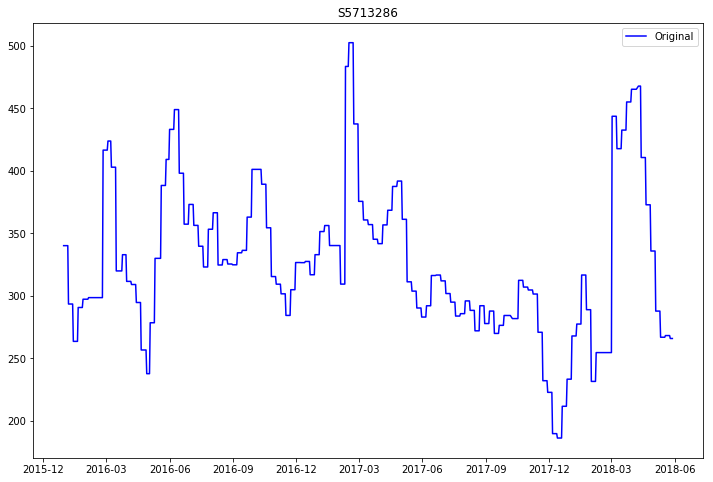

Results of Dickey-Fuller Test:
Test Statistic                  -3.883943
p-value                          0.002156
#Lags Used                       5.000000
Number of Observations Used    622.000000
Critical Value (1%)             -3.440907
Critical Value (5%)             -2.866198
Critical Value (10%)            -2.569251
dtype: float64
The factor is: S0031703


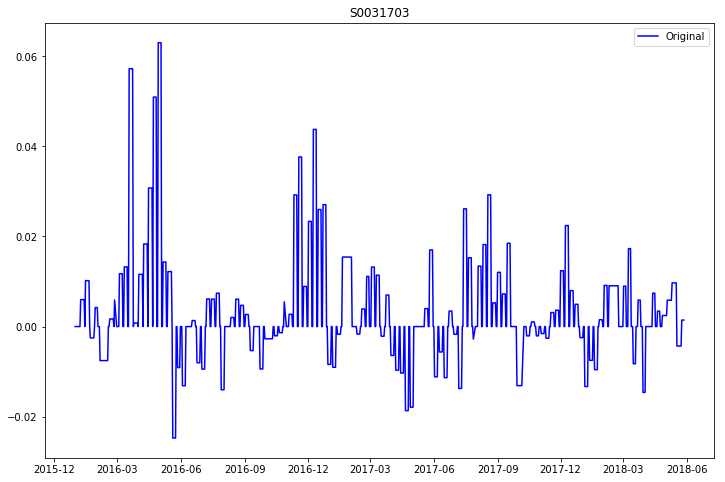

Results of Dickey-Fuller Test:
Test Statistic                  -5.163225
p-value                          0.000010
#Lags Used                       7.000000
Number of Observations Used    620.000000
Critical Value (1%)             -3.440941
Critical Value (5%)             -2.866213
Critical Value (10%)            -2.569259
dtype: float64
The factor is: S0027378


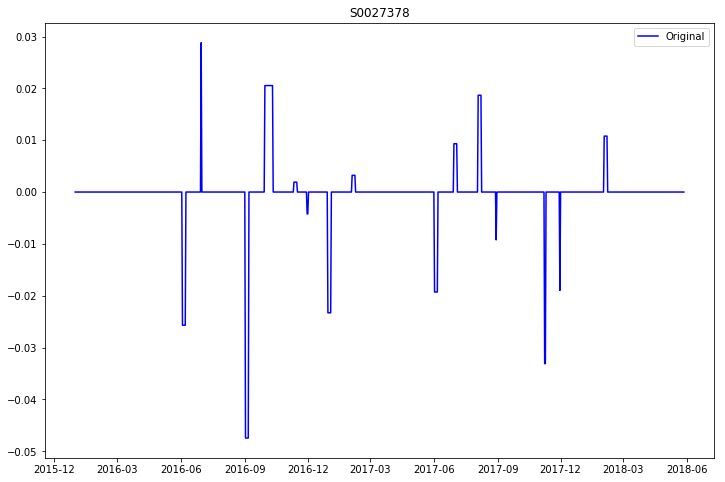

Results of Dickey-Fuller Test:
Test Statistic                -9.144450e+00
p-value                        2.792343e-15
#Lags Used                     3.000000e+00
Number of Observations Used    6.240000e+02
Critical Value (1%)           -3.440873e+00
Critical Value (5%)           -2.866183e+00
Critical Value (10%)          -2.569243e+00
dtype: float64
The factor is: M0251664


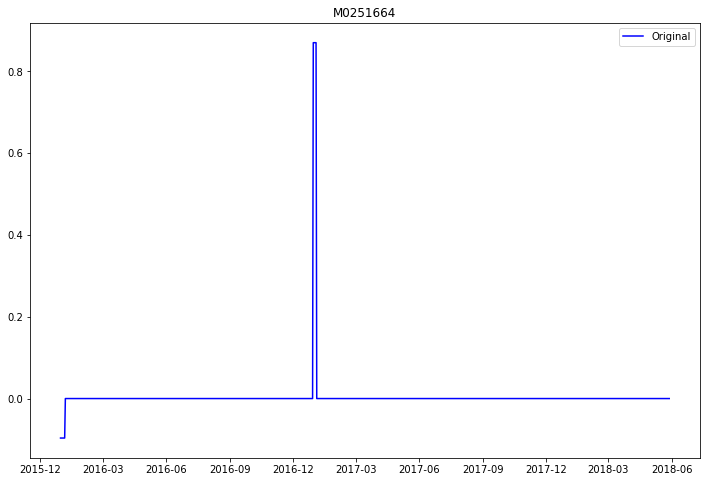

Results of Dickey-Fuller Test:
Test Statistic                  -5.181293
p-value                          0.000010
#Lags Used                      18.000000
Number of Observations Used    609.000000
Critical Value (1%)             -3.441133
Critical Value (5%)             -2.866298
Critical Value (10%)            -2.569304
dtype: float64
The factor is: S5713303


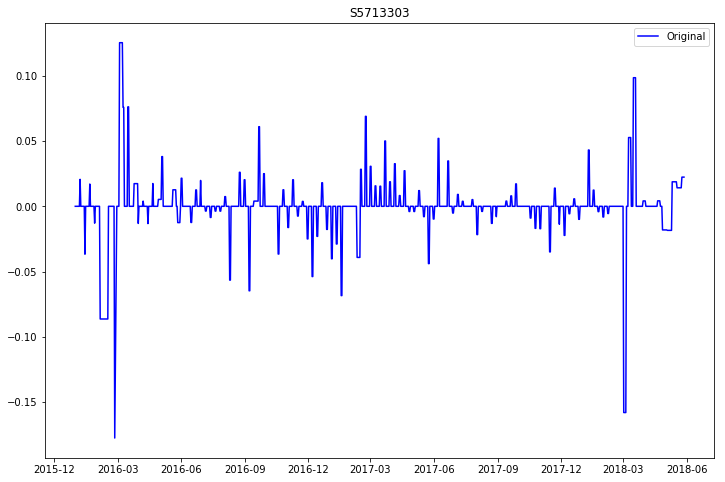

Results of Dickey-Fuller Test:
Test Statistic                -6.471868e+00
p-value                        1.360855e-08
#Lags Used                     1.500000e+01
Number of Observations Used    6.120000e+02
Critical Value (1%)           -3.441080e+00
Critical Value (5%)           -2.866274e+00
Critical Value (10%)          -2.569291e+00
dtype: float64
The factor is: S5713327


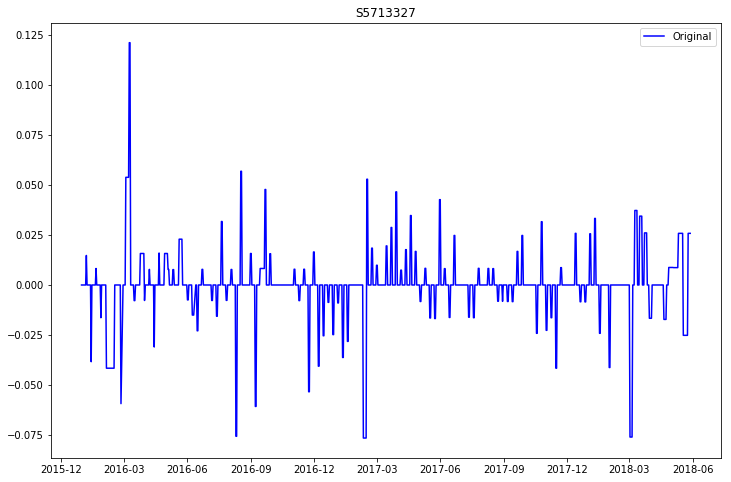

Results of Dickey-Fuller Test:
Test Statistic                -1.112648e+01
p-value                        3.364164e-20
#Lags Used                     3.000000e+00
Number of Observations Used    6.240000e+02
Critical Value (1%)           -3.440873e+00
Critical Value (5%)           -2.866183e+00
Critical Value (10%)          -2.569243e+00
dtype: float64
The factor is: S5713285


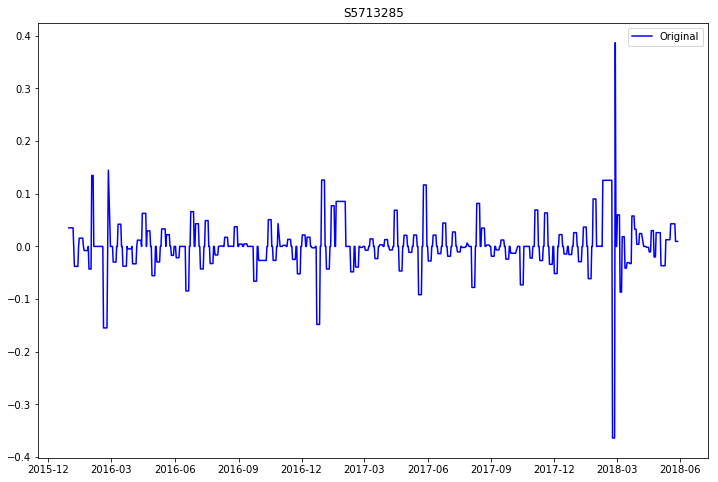

Results of Dickey-Fuller Test:
Test Statistic                -7.809653e+00
p-value                        7.126029e-12
#Lags Used                     7.000000e+00
Number of Observations Used    6.200000e+02
Critical Value (1%)           -3.440941e+00
Critical Value (5%)           -2.866213e+00
Critical Value (10%)          -2.569259e+00
dtype: float64
The factor is: 20-DAYS CHG


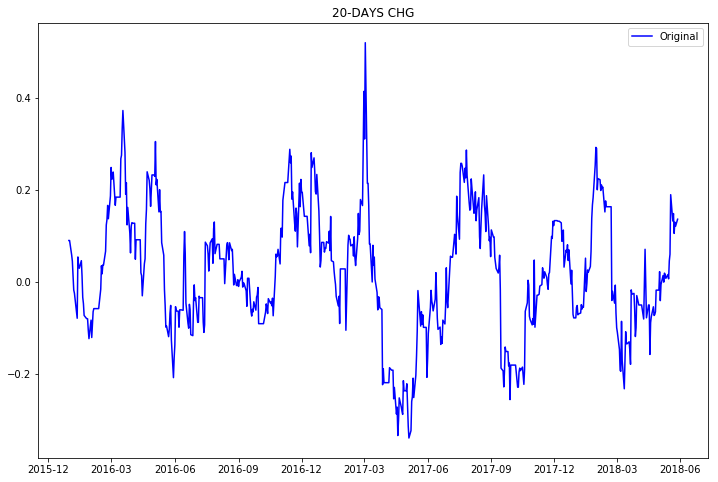

Results of Dickey-Fuller Test:
Test Statistic                  -3.806832
p-value                          0.002838
#Lags Used                       1.000000
Number of Observations Used    626.000000
Critical Value (1%)             -3.440839
Critical Value (5%)             -2.866168
Critical Value (10%)            -2.569235
dtype: float64
The factor is: 40-DAYS CHG


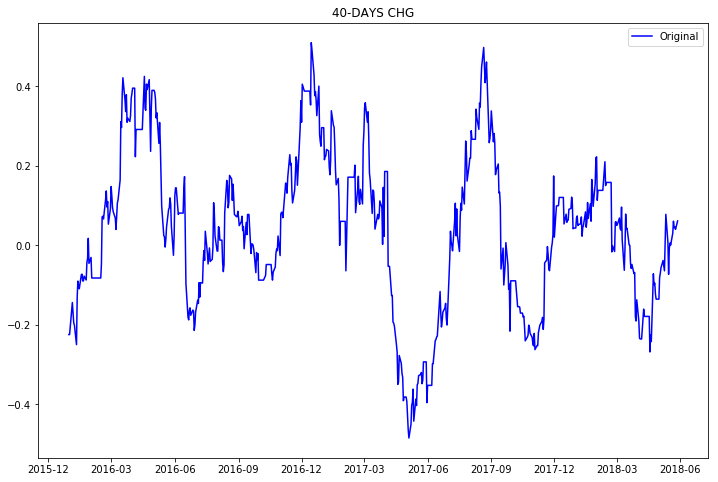

Results of Dickey-Fuller Test:
Test Statistic                  -3.570155
p-value                          0.006358
#Lags Used                      16.000000
Number of Observations Used    611.000000
Critical Value (1%)             -3.441098
Critical Value (5%)             -2.866282
Critical Value (10%)            -2.569295
dtype: float64
S5713339


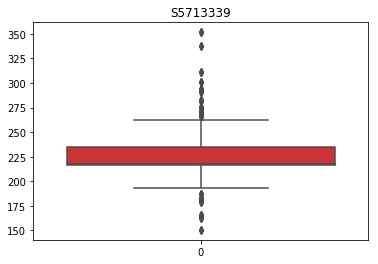

S5713341


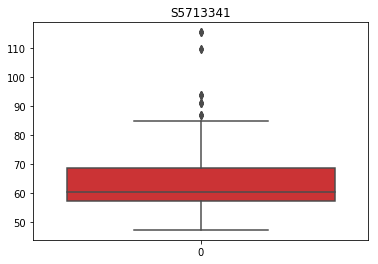

S5713286


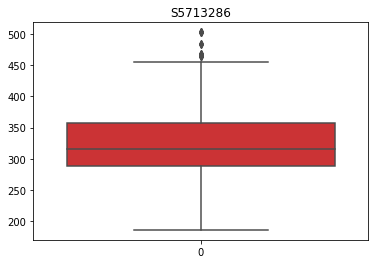

S0031703


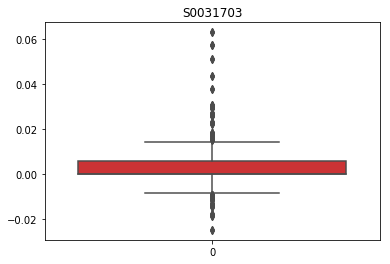

S0027378


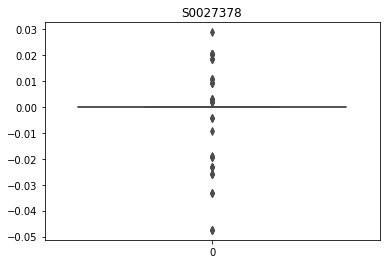

M0251664


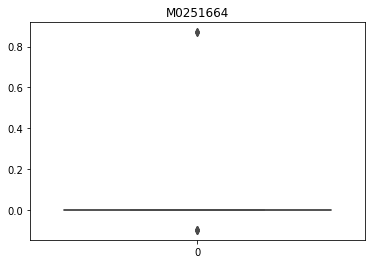

S5713303


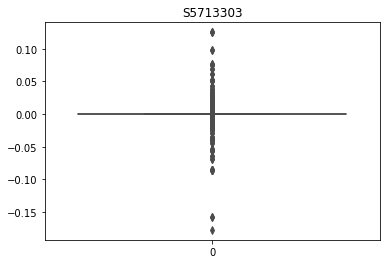

S5713327


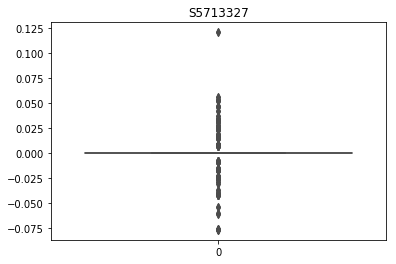

S5713285


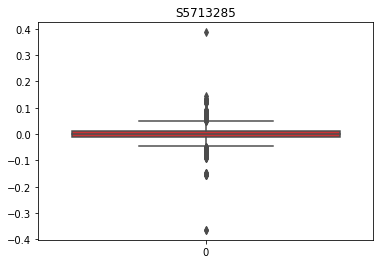

20-DAYS CHG


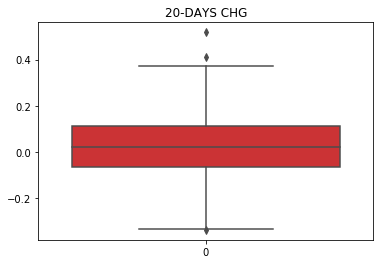

40-DAYS CHG


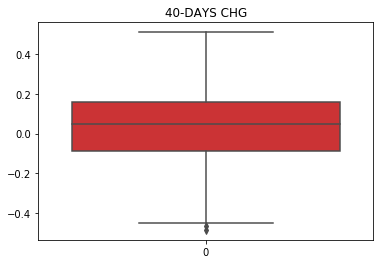

adjusted M0041572


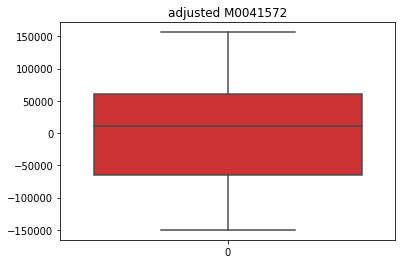

adjusted S5709303


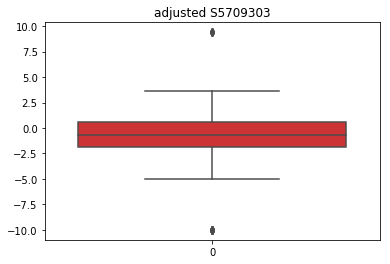

adjusted S5709297


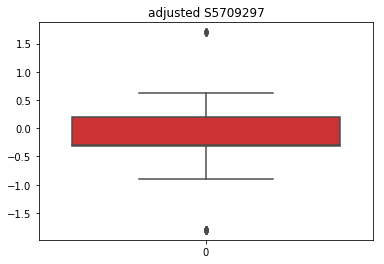

adjusted S0116906


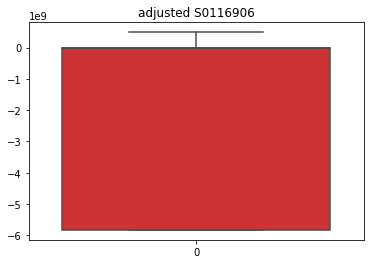

adjusted S0116891


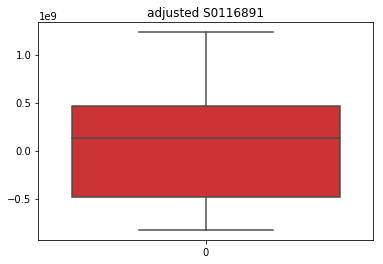

adjusted S0148686


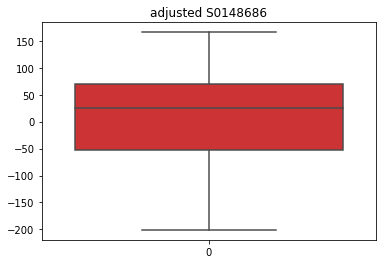

adjusted S5709288


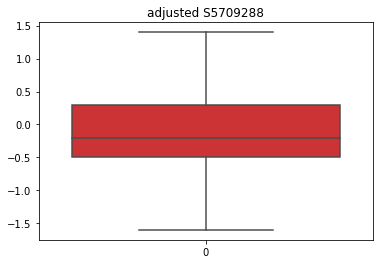

adjusted S5705131


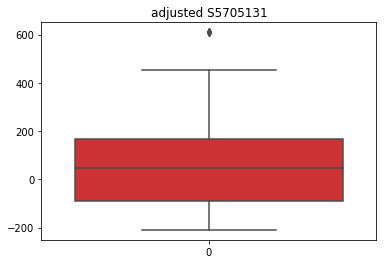

adjusted S5709309


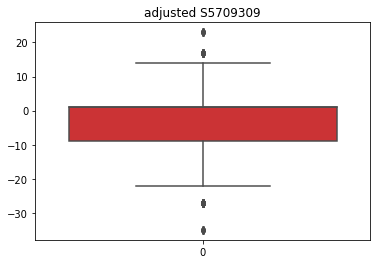

CLOSE


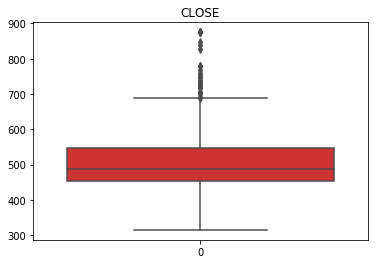

PCT_CHG


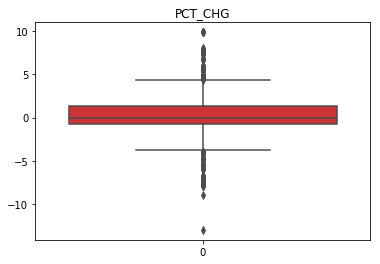

SWING


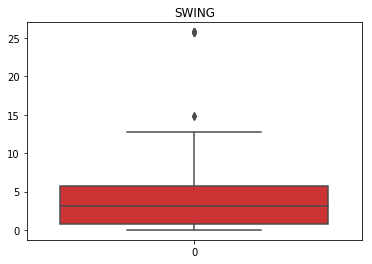

C:\Users\ZYLD\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1904: RuntimeWarning: invalid value encountered in greater
  cond1 = (0 < q) & (q < 1)
C:\Users\ZYLD\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1904: RuntimeWarning: invalid value encountered in less
  cond1 = (0 < q) & (q < 1)


In [5]:
# stationarity test and seasonal adjust
not_stable_factor = FS.test_stationarity(iron_clean.iloc[:,:-3])
FS.seasonal_adjust(not_stable_factor, iron_clean)

# adjust columns
col_list = list(iron_clean)
col_list.insert(len(col_list), col_list.pop(col_list.index('CLOSE')))
col_list.insert(len(col_list), col_list.pop(col_list.index('PCT_CHG')))
col_list.insert(len(col_list), col_list.pop(col_list.index('SWING')))
iron_clean = iron_clean.loc[:, col_list]

# process outliers
FS.box_plot(iron_clean)

norm_adjusted_lst = ['S5713339','S5713286','S0031703','S0027378','M0251664','S5713303','S5713327','S5713285','adjusted S5709309'] # manually input
for i in norm_adjusted_lst:
    iron_clean[i] = FS.norm_inverse(iron_clean[i])
    
iron_clean = iron_clean.replace(np.float64('inf'), 1)
iron_clean = iron_clean.dropna()

In [6]:
# factor score
# observation length = 180 days and predicted length = 10 days
FS.significant_factor(iron_clean, obs_length=180, pred_length=10)

This factor is  S5713339
-0.05756924048863269 0.5853010280747171 1.2850865839423244 3.6087498337573423 21 7
The t value of this factor is  -1.0914661565982704
This factor is  S5713341
-0.03331489997899033 0.2636075079715072 1.361225300510518 0.9198612142261094 19 13
The t value of this factor is  -0.75790713269086
This factor is  S5713286
-0.43439311712164663 0.5334534112678023 1.6920789846596005 0.8205560103427714 13 19
The t value of this factor is  -2.486806787005103
This factor is  S0031703
0.19531190873606588 0.21819890645507473 1.3286719318547604 1.9444551985025758 24 17
The t value of this factor is  -0.057414252062299234
This factor is  S0027378
0.25936293501565555 0.33546014491624354 1.631395805197978 0.22506701765445422 42 2
The t value of this factor is  -0.08317745698315272
This factor is  M0251664
0.26282189910204584 nan 1.5610081434057819 nan 44 0
This factor is not significant.
This factor is  S5713303
0.2564421051327005 0.3967975724582985 1.636237266997506 1.37830624826

In [7]:
# observation length = 360 days and predicted length = 10 days
FS.significant_factor(iron_clean, obs_length=360, pred_length=10)

This factor is  S5713339
0.2240608846860052 -0.6353635038133689 0.02256558222999773 0.8073735639560017 5 2
The t value of this factor is  2.4243401332596974
This factor is  S5713341
nan 0.5106650292480436 nan 1.1623647484312338 0 11
This factor is not significant.
This factor is  S5713286
0.12073235654733687 0.615911305424039 0.030649798553668166 0.7607348114935883 5 20
The t value of this factor is  -1.2440234182514907
This factor is  S0031703
0.18550670334883096 0.7987620544367331 0.4248253781957629 0.6057202863536616 15 8
The t value of this factor is  -2.011137731508447
This factor is  S0027378
0.4935997330725798 0.0 0.6868316965421566 nan 25 1
The t value of this factor is  nan
This factor is  M0251664
0.47461512795440364 nan 0.6687292246992906 nan 26 0
This factor is not significant.
This factor is  S5713303
0.47762282326977895 0.39942274507002085 0.6963479403025282 nan 25 1
The t value of this factor is  nan
This factor is  S5713327
0.4794131343428796 0.3546649682425057 0.695969

In [8]:
print("Factor Selection Done!")

Factor Selection Done!


### Factor Processing

In [9]:
# reload and process factor
select_fac = w.edb("S5713286,S5709297,S5713339,S0031703", startdate, enddate,"Fill=Previous")
wind_to_df = lambda x: pd.DataFrame(x.Data, columns=x.Times, index=x.Codes).T
select_fac = wind_to_df(select_fac)
select_fac.index=pd.to_datetime(select_fac.index)

iron_price = w.wsd("I00.DCE", "close,pct_chg,swing", startdate, enddate, "TradingCalendar=DCE")
wind_to_df = lambda x: pd.DataFrame(x.Data, columns=x.Times,index=x.Fields).T
iron_price = wind_to_df(iron_price)

In [10]:
# put selected factors into lists according to update frequency
weekly_f = ['S5713286','S5713339','S0031703']
daily_f = ['S5709297']
# process lag info
fac_lagadj = FS.update_lag(select_fac, weekly_factor=weekly_f, daily_factor=daily_f)

# better use margin value for demand factor
demand_fac = ['S0031703']
for fac in demand_fac:
    fac_lagadj[fac] = FS.margin(fac_lagadj, fac, 1)

# concat factors and prices data
fac_reindex = fac_lagadj.reindex(iron_price.index)
fac_concat = pd.concat([fac_reindex, iron_price], axis=1)

# clean data
fac_clean = FS.raw_data_clean(fac_concat).get_newdata().ffill()

number of missing values for each column:
S5713286    1002
S5709297     924
S5713339    1009
S0031703     905
CLOSE        102
PCT_CHG      102
SWING        534
dtype: int64
The time span of this dataset is:
 2015-04-17 00:00:00 - 2018-05-28 00:00:00


The factor is: S5713286


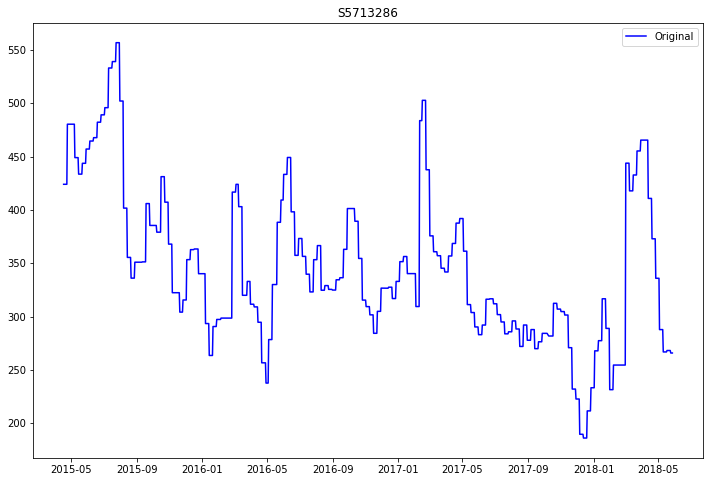

Results of Dickey-Fuller Test:
Test Statistic                  -3.900794
p-value                          0.002029
#Lags Used                       5.000000
Number of Observations Used    806.000000
Critical Value (1%)             -3.438489
Critical Value (5%)             -2.865133
Critical Value (10%)            -2.568683
dtype: float64
The factor is: S5709297


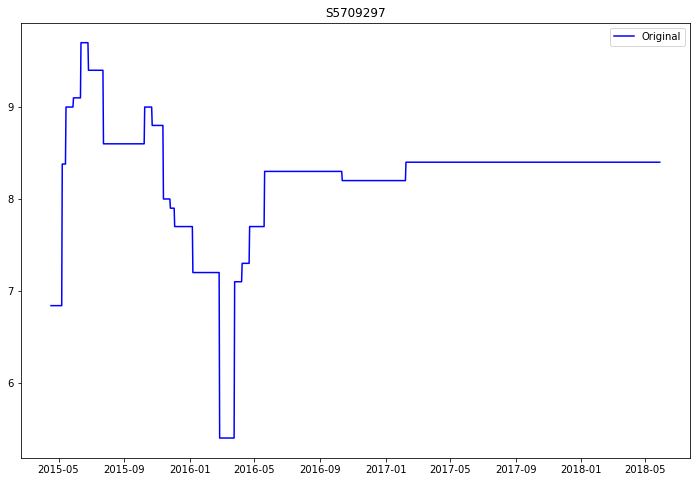

Results of Dickey-Fuller Test:
Test Statistic                  -3.021737
p-value                          0.032914
#Lags Used                       0.000000
Number of Observations Used    811.000000
Critical Value (1%)             -3.438439
Critical Value (5%)             -2.865110
Critical Value (10%)            -2.568671
dtype: float64

The series is not smooth, please do seasonal adjustment.
The factor is: S5713339


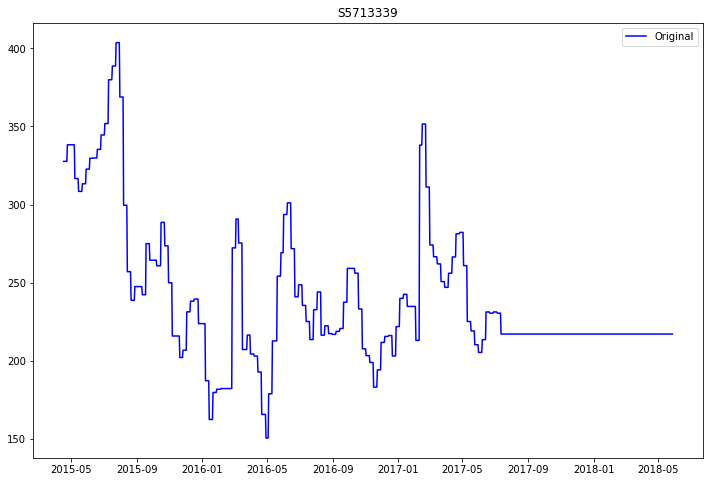

Results of Dickey-Fuller Test:
Test Statistic                  -3.770302
p-value                          0.003226
#Lags Used                       8.000000
Number of Observations Used    803.000000
Critical Value (1%)             -3.438520
Critical Value (5%)             -2.865146
Critical Value (10%)            -2.568690
dtype: float64
The factor is: S0031703


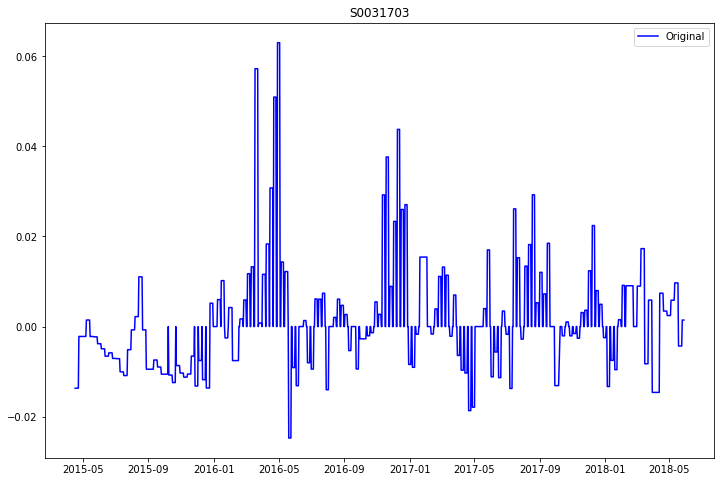

Results of Dickey-Fuller Test:
Test Statistic                  -5.350569
p-value                          0.000004
#Lags Used                       7.000000
Number of Observations Used    804.000000
Critical Value (1%)             -3.438510
Critical Value (5%)             -2.865142
Critical Value (10%)            -2.568688
dtype: float64


In [11]:
# stationarity test and seasonal adjust
not_stable_factor = FS.test_stationarity(fac_clean.iloc[:,:-3])
FS.seasonal_adjust(not_stable_factor, fac_clean)

# adjust columns
col_list = list(fac_clean)
col_list.insert(len(col_list), col_list.pop(col_list.index('CLOSE')))
col_list.insert(len(col_list), col_list.pop(col_list.index('PCT_CHG')))
col_list.insert(len(col_list), col_list.pop(col_list.index('SWING')))
fac_clean = fac_clean.loc[:, col_list].dropna()

# process outliers
norm_adjusted_lst=list(fac_clean.iloc[:,:-3])
for i in norm_adjusted_lst:
    fac_clean[i] = FS.norm_inverse(fac_clean[i])
    
fac_clean = fac_clean.replace(np.float64('inf'), 1)
fac_clean = fac_clean.dropna()

### Backtest 1: use 4 factors obtained from 180 observation length

In [12]:
# equally weighted
positive_fac = ['S0031703']
negative_fac = ['S5713286','S5713339', 'adjusted S5709297']

iron_score = pd.DataFrame()
for fac in  positive_fac:
    mini_score = FS.factor_score(fac_clean, fac, obs_length=180, pred_length=10, direction=1)
    mini_score = mini_score.drop(['underlying_asset_rate'], axis=1)
    iron_score = pd.concat([iron_score, mini_score], axis=1)

for fac in negative_fac:
    mini_score = FS.factor_score(fac_clean, fac, obs_length=180, pred_length=10, direction=0)
    mini_score = mini_score.drop(['underlying_asset_rate'], axis=1)
    iron_score = pd.concat([iron_score, mini_score], axis=1)

iron_score = FS.equally_weighted(iron_score)
iron_score=  pd.concat([iron_score,pd.DataFrame(fac_clean["CLOSE"][iron_score.index])], axis=1)

total cost: 711.34
profit: [0.0, 0.0, 0.0, 0.0, 0.0, 3550.0, -6400.0, 0.0, 0.0, 0.0, 0, -0.0, -0.0, -0.0, -0.0, 0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -2850.0, 0.0, 0.0, 0.0, 0.0, 600.0, 3500.0, 0.0, 3400.0, -0.0, -0.0, -0.0, -0.0, -0.0, 6650.0, 0.0, 0.0, 0, -0.0, -1650.0, 0.0, 0.0, 0.0, 0.0, 950.0, -0.0, -0.0, -0.0, -4100.0, 0.0, 0, -0.0, -0.0, -0.0, 0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]
culmulative profit: [    0.     0.     0.     0.     0.  3550. -2850. -2850. -2850. -2850.
 -2850. -2850. -2850. -2850. -2850. -2850. -2850. -2850. -2850. -2850.
 -2850. -2850. -5700. -5700. -5700. -5700. -5700. -5100. -1600. -1600.
  1800.  1800.  1800.  1800.  1800.  1800.  8450.  8450.  8450.  8450.
  8450.  6800.  6800.  6800.  6800.  6800.  7750.  7750.  7750.  7750.
  3650.  3650.  3650.  3650.  3650.  3650.  3650.  3650.  3650.  3650.
  3650.  3650.  3650.]
Needed initial cash is: 13125.0 culmulative return is: 0.2780952380952381


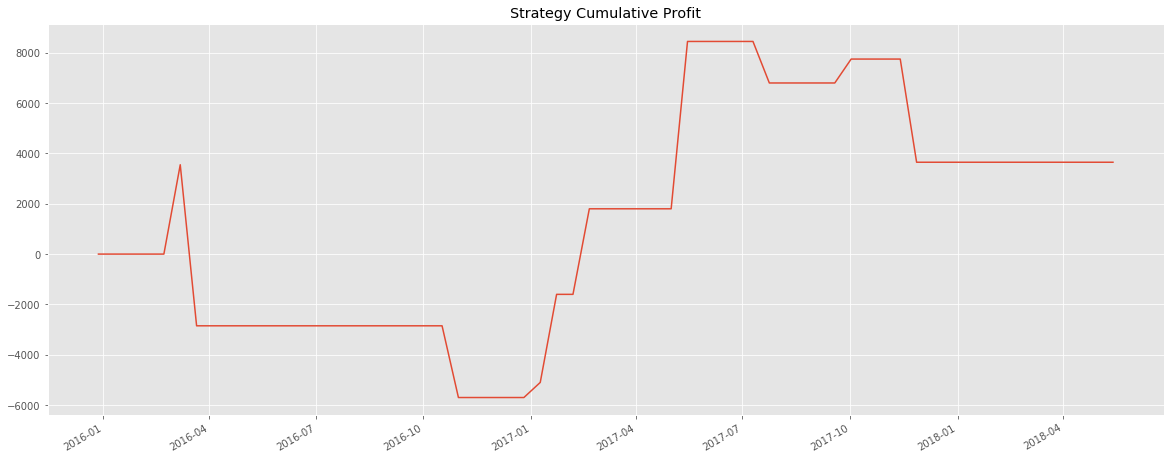

In [13]:
# setting: trade for 100 lots; transaction fees = 0.024% * trading volume
profit = FS.cal_profit(iron_score['CLOSE'],iron_score["weighted_score"])

In [14]:
# calculate max drawdown
cul_profit = np.array(profit).cumsum()
idx = np.argmax(np.maximum.accumulate(cul_profit)-cul_profit)
FS.max_drawdown(cul_profit[idx:])

0.5680473372781065

### Backtest 2: use 2 factors obtained from 360 observation length

In [15]:
# equally weighted
positive_fac = ['S0031703']
negative_fac = ['S5713339']

iron_score2 = pd.DataFrame()
for fac in  positive_fac:
    mini_score = FS.factor_score(fac_clean, fac, obs_length=180, pred_length=10, direction=1)
    mini_score = mini_score.drop(['underlying_asset_rate'], axis=1)
    iron_score2 = pd.concat([iron_score2, mini_score], axis=1)

for fac in negative_fac:
    mini_score = FS.factor_score(fac_clean, fac, obs_length=180, pred_length=10, direction=0)
    mini_score = mini_score.drop(['underlying_asset_rate'], axis=1)
    iron_score2 = pd.concat([iron_score2, mini_score], axis=1)

iron_score2 = FS.equally_weighted(iron_score2)
iron_score2 = pd.concat([iron_score2,pd.DataFrame(fac_clean["CLOSE"][iron_score2.index])], axis=1)

total cost: 698.78
profit: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -2100.0, -0.0, -0.0, -3000.0, 0.0, 1350.0, -1700.0, 0.0, 0, -0.0, -0.0, -2850.0, 0.0, 0.0, 0.0, 0.0, 600.0, 3500.0, 0.0, 0.0, 0, -0.0, -0.0, -0.0, -0.0, 6650.0, 0.0, 0.0, 0.0, 7300.0, -1650.0, 0.0, 0.0, 0.0, 0.0, 950.0, -0.0, -0.0, -0.0, -4100.0, 0.0, 0, -0.0, -0.0, -0.0, 0, 0, -0.0, -0.0, -0.0, -0.0, -0.0]
culmulative profit: [    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0. -2100. -2100. -2100. -5100. -5100. -3750. -5450. -5450. -5450.
 -5450. -5450. -8300. -8300. -8300. -8300. -8300. -7700. -4200. -4200.
 -4200. -4200. -4200. -4200. -4200. -4200.  2450.  2450.  2450.  2450.
  9750.  8100.  8100.  8100.  8100.  8100.  9050.  9050.  9050.  9050.
  4950.  4950.  4950.  4950.  4950.  4950.  4950.  4950.  4950.  4950.
  4950.  4950.  4950.]
Needed initial cash is: 13125.0 culmulative return is: 0.37714285714285717


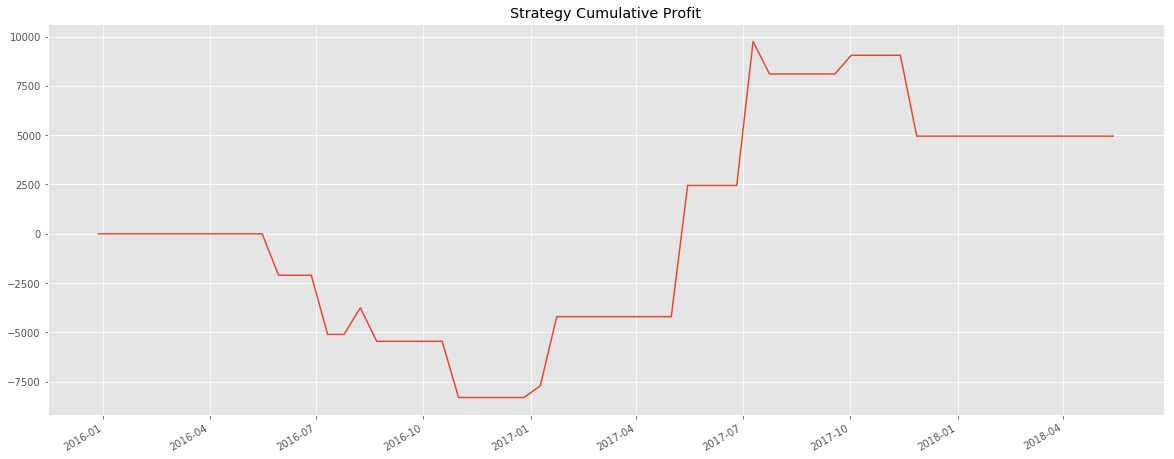

In [16]:
profit2 = FS.cal_profit(iron_score2['CLOSE'],iron_score2["weighted_score"])

In [18]:
# calculate max drawdown
cul_profit2 = np.array(profit2).cumsum()
idx = np.argmax(np.maximum.accumulate(cul_profit2)-cul_profit2)
FS.max_drawdown(cul_profit2[idx:])

0.49230769230769234

### Backtest 3: 180日观察窗口得出的2个因子

In [19]:
# equally weighted
negative_fac = ['adjusted S5709297','S5713286']

iron_score3 = pd.DataFrame()
# for fac in  positive_fac:
#     mini_score = FS.factor_score(fac_clean, fac, obs_length=180, pred_length=10, direction=1)
#     mini_score = mini_score.drop(['underlying_asset_rate'], axis=1)
#     iron_score3 = pd.concat([iron_score3, mini_score], axis=1)

for fac in negative_fac:
    mini_score = FS.factor_score(fac_clean, fac, obs_length=180, pred_length=10, direction=0)
    mini_score = mini_score.drop(['underlying_asset_rate'], axis=1)
    iron_score3 = pd.concat([iron_score3, mini_score], axis=1)

iron_score3 = FS.equally_weighted(iron_score3)
iron_score3 = pd.concat([iron_score3,pd.DataFrame(fac_clean["CLOSE"][iron_score3.index])], axis=1)

total cost: 556.63
profit: [0.0, 0.0, 0.0, 0.0, 0.0, 3550.0, -0.0, 0, 0, 0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 3400.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0, 0, -0.0, -0.0, 0, 0, 0, 0, 0, 0, 0, -0.0, -0.0, -0.0, 0, 0, 0, -0.0, -0.0, 0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]
culmulative profit: [   0.    0.    0.    0.    0. 3550. 3550. 3550. 3550. 3550. 3550. 3550.
 3550. 3550. 3550. 3550. 3550. 3550. 3550. 3550. 3550. 3550. 3550. 3550.
 3550. 3550. 3550. 3550. 3550. 3550. 6950. 6950. 6950. 6950. 6950. 6950.
 6950. 6950. 6950. 6950. 6950. 6950. 6950. 6950. 6950. 6950. 6950. 6950.
 6950. 6950. 6950. 6950. 6950. 6950. 6950. 6950. 6950. 6950. 6950. 6950.
 6950. 6950. 6950.]
Needed initial cash is: 13125.0 culmulative return is: 0.5295238095238095


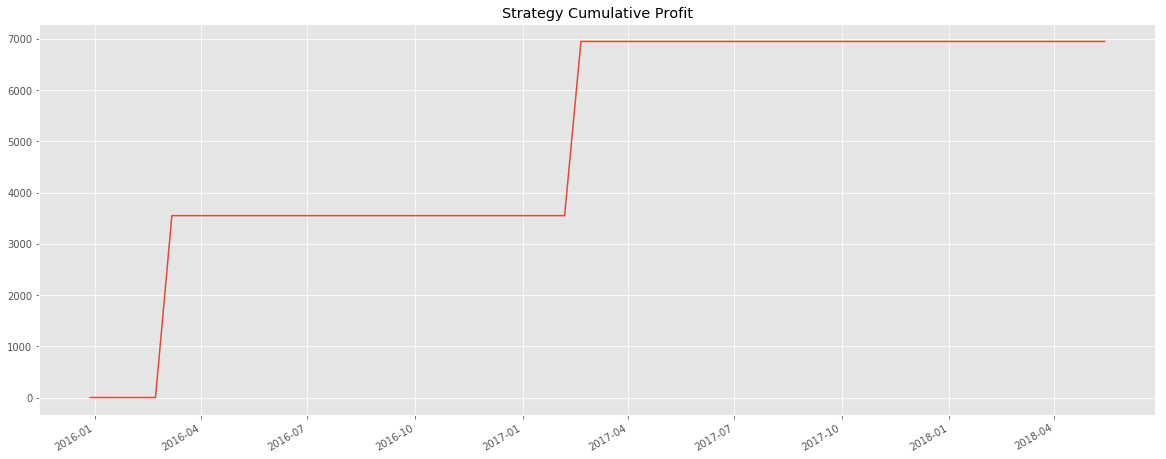

In [20]:
profit3 = FS.cal_profit(iron_score3['CLOSE'],iron_score3["weighted_score"])

In [21]:
print("Done")

Done
